In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./../../../designer/script/')
sys.path.append('./../../')
sys.path.append('./../../../')
# framework
from design import BaseDesign
from film import TwoMaterialFilm
from spectrum import Spectrum
from analyze_utils.make_design import get_edge_filter_design
# optimizer
from optimizer.archive.LM_gradient_descent import LM_optimize_d_simple
from optimizer.adam import AdamThicknessOptimizer
# others
import copy
import pickle
from analyze_utils.color import cold_qualitative, qualitative
from numpy import save


In [3]:


wls = np.linspace(400, 1000, 500)
target_spec = get_edge_filter_design(inc=0., wls=wls)

show = False

def convergence(layers, max_step, optimizer, seed):
    # make design for adam
    total_gt = 3000
    np.random.seed(seed)
    init_film = TwoMaterialFilm('SiO2', 'TiO2', 'SiO2', np.random.random(layers) * total_gt / layers)
    
    # use the same seed
    # np.random.seed(0)
    # target_film = TwoMaterialFilm('SiO2', 'TiO2', 'SiO2', np.random.random(100) * total_gt / 10)
    # target_film.add_spec_param(0., wls)
    # target_film.calculate_spectrum()
    # target_spec = target_film.get_all_spec_list()[0]
    
    design_adam = BaseDesign([target_spec], init_film)

    if optimizer == 'adam':
        adam_optimizer = AdamThicknessOptimizer(design_adam.film, [target_spec], max_step, alpha=1, record=True, show=show)
        _, losses = adam_optimizer.optimize()

    if optimizer == 'LM':
        design_LM = BaseDesign([target_spec], copy.deepcopy(design_adam.init_film))
        steps, losses = LM_optimize_d_simple(design_LM.film, [target_spec], h_tol=1e-200, max_step=max_step, record=True, show=show)

    return losses

def rep(layers, max_step, rep_num = 5):
    losses_LM = []
    losses_adam = []
    for i in range(rep_num):
        losses_LM.append(convergence(layers, max_step, 'LM', i))
        losses_adam.append(convergence(layers, max_step, 'adam', i))

    # fill early stopped ls with last value
    for reps in losses_LM:
        if len(reps) < max_step + 1:
            reps += [reps[-1]] * (max_step + 1 - len(reps))
            
    losses_LM = np.array(losses_LM)
    losses_adam = np.array(losses_adam)
    return losses_LM, losses_adam


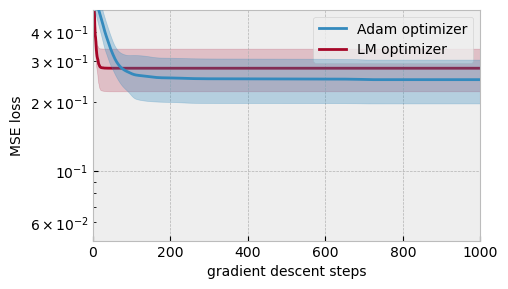

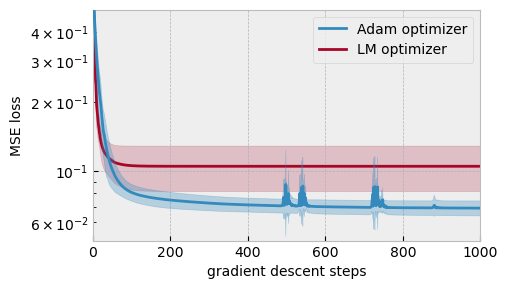

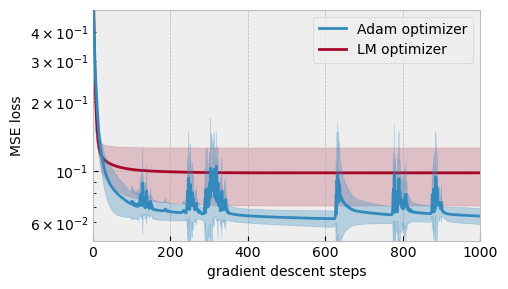

In [9]:
def plot(ax, y_arr, x=None, alpha=0.3, label=None, **kwargs):
    if x is None:
        x = np.arange(np.array(y_arr).shape[1])
    if type(y_arr) is list:
        y_arr = np.array(y_arr)

    ax.plot(x, y_arr.mean(0), label=label,**kwargs)

    means = y_arr.mean(0)
    stds = y_arr.std(0)
    
    ax.fill_between(x, means + stds, means - stds, alpha=alpha, **kwargs)

def plot_outer():
    fig, ax = plt.subplots(1, 1)

    plot(ax, losses_adam, label='Adam optimizer', color='C0', alpha=0.3, zorder=10)
    plot(ax, losses_LM, label='LM optimizer', color='C1', alpha=0.2)

    ax.legend(loc='upper right')
    ax.set_yscale('log')
    ax.set_xlabel('gradient descent steps')
    ax.set_ylabel('MSE loss')
    ax.set_xlim(0, 1000)
    ax.set_ylim(5e-2, 5e-1)

    fig.set_size_inches(5, 3)
    fig.savefig(f'{layer_num}_layers_edge_filter_compare.png', dpi=300, bbox_inches='tight')
    plt.show()



for layer_num in [10, 100, 200]:
    # losses_LM, losses_adam = rep(layer_num, 2000, rep_num=5)

    # np.save(f'./result_{layer_num}layers_LM', losses_LM)
    # np.save(f'./result_{layer_num}layers_adam', losses_adam)

    with open(f'./result_{layer_num}layers_LM.npy', 'rb') as f:
        losses_LM = np.load(f)
    
    with open(f'./result_{layer_num}layers_adam.npy', 'rb') as f:
        losses_adam = np.load(f)
    
    with plt.style.context('bmh'):
        plot_outer()
